In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib

# Path, Names and configuration
Please change the DataPathPrefix, if you don't use the Data folder in the Root folder.

In [2]:
## Parameter-------------------------------------------------------

#Please change this Path, if you store the data not in the Data folder of the repo.
DataPathPrefix=os.path.split(os.getcwd())[0]+"/Data"


NamesPrint={'GeNN-\nProc': ("GeNN-\nPr-S3", 3), 'GeNN-\nProc_Old': ("GeNN-\nPr-S1", 4), 
            'GeNN-\nProc': ("GeNN-\nPr-S3", 3), 'GeNN-\nProc_old': ("GeNN-\nPr-S1", 4), 
            'GeNN-\nSparse': ("GeNN-\nSp-S3", 5), 'GeNN-\nSparse_Old': ("GeNN-\nSp-S1",6),
            'GeNN-\nSparse': ("GeNN-\nSp-S3", 5), 'GeNN-\nSparse_old': ("GeNN-\nSp-S1",6),
           'Nest': ("NEST-S3",1), 'Nest_Old': ("NEST-S2",2),
           'Nest': ("NEST-S3",1), 'Nest_old': ("NEST-S2",2)}


fontsizeTicks=8
fontsizeLabels=10
fontsizeSubfigure=14
fontsizeLegend=8
markersize=3

cm = 1/2.54  # centimeters in inches

cmap = mpl.cm.get_cmap('tab20c')
cmap_Var= mpl.cycler(color=[cmap(0.0), cmap(0.05), cmap(0.2), cmap(0.25), cmap(0.4), cmap(0.45), cmap(0.1), cmap(0.15), cmap(0.3), cmap(0.35), cmap(0.5), cmap(0.55)])
cmap = mpl.cm.get_cmap('tab20b')
cmap_Bar = mpl.cycler(color=[cmap(0.0), cmap(0.6), cmap(0.2)])



PathsVariableSize=[("Genn_old",DataPathPrefix+"/TimeSim_Size/GeNN_S1.pkl"),
       			   ("Genn_old",DataPathPrefix+"/TimeSim_Size/GeNN_S1_extend.pkl"),
                   ("Nest_old",DataPathPrefix+"/TimeSim_Size/NEST_S2.pkl"),
                   ("Nest_old",DataPathPrefix+"/TimeSim_Size/NEST_S2_extend.pkl"),
                   ("Genn",DataPathPrefix+"/TimeSim_Size/GeNN_S3.pkl"),
                   ("Genn",DataPathPrefix+"/TimeSim_Size/GeNN_S3_extend.pkl"),
                   ("Nest",DataPathPrefix+"/TimeSim_Size/NEST_S3.pkl")]

PathRT=[("Genn_old",DataPathPrefix+"/TimeSim_Size/RT/GeNN_S1_RT.pkl"),
       ("Nest_old",DataPathPrefix+"/TimeSim_Size/RT/NEST_S2_RT.pkl"),
       ("Genn",DataPathPrefix+"/TimeSim_Size/RT/GeNN_S3_RT.pkl"),
        ("Nest",DataPathPrefix+"/TimeSim_Size/RT/NEST_S3_RT.pkl")]

Path5k_50k=[("Genn_Old",DataPathPrefix+"/TimeBiol_Sim/GeNN_S1.pkl"),
       		("Nest_Old",DataPathPrefix+"/TimeBiol_Sim/NEST_S2.pkl"),
         	("Nest",DataPathPrefix+"/TimeBiol_Sim/NEST_S3.pkl"),
      		("Genn",DataPathPrefix+"/TimeBiol_Sim/GeNN_S3.pkl")]

# Functions

In [3]:
#Functions for Conversion between M and N
def NtoM(x):
    return (x**2) * 0.308

def NtoM9(x):
    return NtoM(x)/1e9

def MtoN(x):
    return np.sqrt(x) /np.sqrt(0.308)
    
def M9toN(x):
    return MtoN(x*1e9)

#Functions for Loading
def LoadData(Datapath):
    RowsLoaded=0
    data=[]
    for  (Simulator,PathX) in Datapath:
        with open(PathX, 'rb') as f:
            try:
                while True:
                    dataLoc=pickle.load(f)

                    resultDict={'Backend': Simulator}
                    resultDict['e_rate']=dataLoc['e_rate']
                    resultDict.update(dataLoc['Timing'])
                    resultDict.update(dataLoc['params'])
                    try:
                        if resultDict["e_rate"]==-1:
                            resultDict["Sim"]=[np.nan]
                            resultDict["Download"]=[np.nan]
                            resultDict["Multi"]=0          
                                
                        elif type(resultDict["Sim"])==float:
                            resultDict["Sim"]=[resultDict["Sim"]]
                            resultDict["Download"]=[resultDict["Download"]]
                            resultDict["Multi"]=0   
                        elif len(resultDict["Sim"]) >1:
                            resultDict["Multi"]=len(resultDict["Sim"])
                            resultDict["Sim"]=[np.sum(resultDict["Sim"])]
                            resultDict["Download"]=[np.sum(resultDict["Download"])]
                            
                    except Exception as e:
                        if(Simulator=="Nest"):
                            print(e)
                        resultDict["Sim"]=[np.nan]
                        resultDict["Download"]=[np.nan]
                        resultDict["Multi"]=0
                    data.append(resultDict)
                    RowsLoaded+=1
            except:
                #pass
                print("Loaded: " + PathX)
    
    print("Total number of Rows loaded: ", RowsLoaded)
    df = pd.DataFrame(data)
    return df


def GenerateName(Backend, MatrixType):
    if "Genn" in Backend:
        if Backend=="Genn":
            if MatrixType=="PROCEDURAL_GLOBALG":
                return "GeNN-\nProc"
            elif MatrixType=="SPARSE_GLOBALG":
                return "GeNN-\nSparse"
            else:
                return "GeNN"
        else:
            tmpStr=Backend.replace("Genn", "")
            if MatrixType=="PROCEDURAL_GLOBALG":
                return "GeNN-\nProc"+tmpStr
            elif MatrixType=="SPARSE_GLOBALG":
                return "GeNN-\nSparse"+tmpStr
            else:
                return "GeNN"+tmpStr
        
    elif Backend=="Nest":
        return "Nest"
    else:
        return Backend
    
    

# Load Data Figure 3+4

In [4]:
#Variable Size
df_variableSize=LoadData(PathsVariableSize)
df_variableSize["Print"]=df_variableSize.apply(lambda x: GenerateName(x.Backend, x.matrixType), axis=1)
df_variableSize["TotalBiol"]=df_variableSize.apply(lambda x: (x.simtime+x.warmup)/1000, axis=1)
df_variableSize["RT"]=df_variableSize.apply(lambda x: (np.sum(x.Sim)+np.sum(x.Download))/x.TotalBiol, axis=1)
df_variableSize['TotalFix']=df_variableSize.apply(lambda x: x.Build+x.Compile+x.Load, axis=1)
df_variableSize=df_variableSize.groupby(['N_E','Print']).agg({"TotalFix": "mean", "e_rate": "median", "RT": "median"}).reset_index()

## drop Nest values which used swap
df_variableSize.drop(df_variableSize[(df_variableSize['Print']=='Nest_old') & (df_variableSize['N_E']>100000)].index, inplace=True)
df_variableSize.reset_index(inplace=True)

# 5k/50k
df_5k_50k=LoadData(Path5k_50k)
df_5k_50k["Print"]=df_5k_50k.apply(lambda x: GenerateName(x.Backend, x.matrixType), axis=1)

df_5k_50k_Fixcost=df_5k_50k[df_5k_50k['warmup'] == 0]
df_5k_50k_Fixcost=df_5k_50k_Fixcost.filter(items=['Print', 'Build', 'Compile', 'Load', 'N_E'])
df_5k_50k_Fixcost['TotalFix']=df_5k_50k_Fixcost.apply(lambda x: x.Build + x.Compile + x.Load, axis=1)
df_5k_50k_Fixcost=df_5k_50k_Fixcost.groupby(['N_E', 'Print']).mean().reset_index()
df_5k_50k_Fixcost['Sort']=df_5k_50k_Fixcost['Print'].apply(lambda x: NamesPrint[x][1])
df_5k_50k_Fixcost['Print']=df_5k_50k_Fixcost['Print'].apply(lambda x: NamesPrint[x][0])
df_5k_50k_Fixcost.sort_values(['N_E', 'Sort'], inplace=True)
df_5k_50k_Fixcost.reset_index(inplace=True)


df_5k_50k_Variable=df_5k_50k.loc[(df_5k_50k['warmup']>0) & (df_5k_50k['e_rate'])]                                
df_5k_50k_Variable.insert(0, 'TotalSim', df_5k_50k_Variable['Sim'].apply(np.sum), True)   
df_5k_50k_Variable.insert(0, 'TotalBiol', df_5k_50k_Variable.apply(lambda x: (x.warmup + x.simtime)/1000, axis=1), True)   
df_5k_50k_Variable.insert(0, 'TotalDownload', df_5k_50k_Variable['Download'].apply(np.sum), True)  
df_5k_50k_Variable.insert(0, 'TotalDyn', df_5k_50k_Variable.apply(lambda x: x.TotalDownload + x.TotalSim, axis=1), True) 
df_5k_50k_Variable=df_5k_50k_Variable.filter(items=['Print','TotalDyn', 'N_E', 'TotalBiol'])



Loaded: /home/felix/Documents/BenchmarkGeNN/RepoPublication/SNN_GeNN_Nest/Data/TimeSim_Size/GeNN_S1.pkl
Loaded: /home/felix/Documents/BenchmarkGeNN/RepoPublication/SNN_GeNN_Nest/Data/TimeSim_Size/GeNN_S1_extend.pkl
Loaded: /home/felix/Documents/BenchmarkGeNN/RepoPublication/SNN_GeNN_Nest/Data/TimeSim_Size/NEST_S2.pkl
Loaded: /home/felix/Documents/BenchmarkGeNN/RepoPublication/SNN_GeNN_Nest/Data/TimeSim_Size/NEST_S2_extend.pkl
Loaded: /home/felix/Documents/BenchmarkGeNN/RepoPublication/SNN_GeNN_Nest/Data/TimeSim_Size/GeNN_S3.pkl
Loaded: /home/felix/Documents/BenchmarkGeNN/RepoPublication/SNN_GeNN_Nest/Data/TimeSim_Size/GeNN_S3_extend.pkl
Loaded: /home/felix/Documents/BenchmarkGeNN/RepoPublication/SNN_GeNN_Nest/Data/TimeSim_Size/NEST_S3.pkl
Total number of Rows loaded:  1649
Loaded: /home/felix/Documents/BenchmarkGeNN/RepoPublication/SNN_GeNN_Nest/Data/TimeBiol_Sim/GeNN_S1.pkl
Loaded: /home/felix/Documents/BenchmarkGeNN/RepoPublication/SNN_GeNN_Nest/Data/TimeBiol_Sim/NEST_S2.pkl
Loaded: 

# Figure 3

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:134: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.


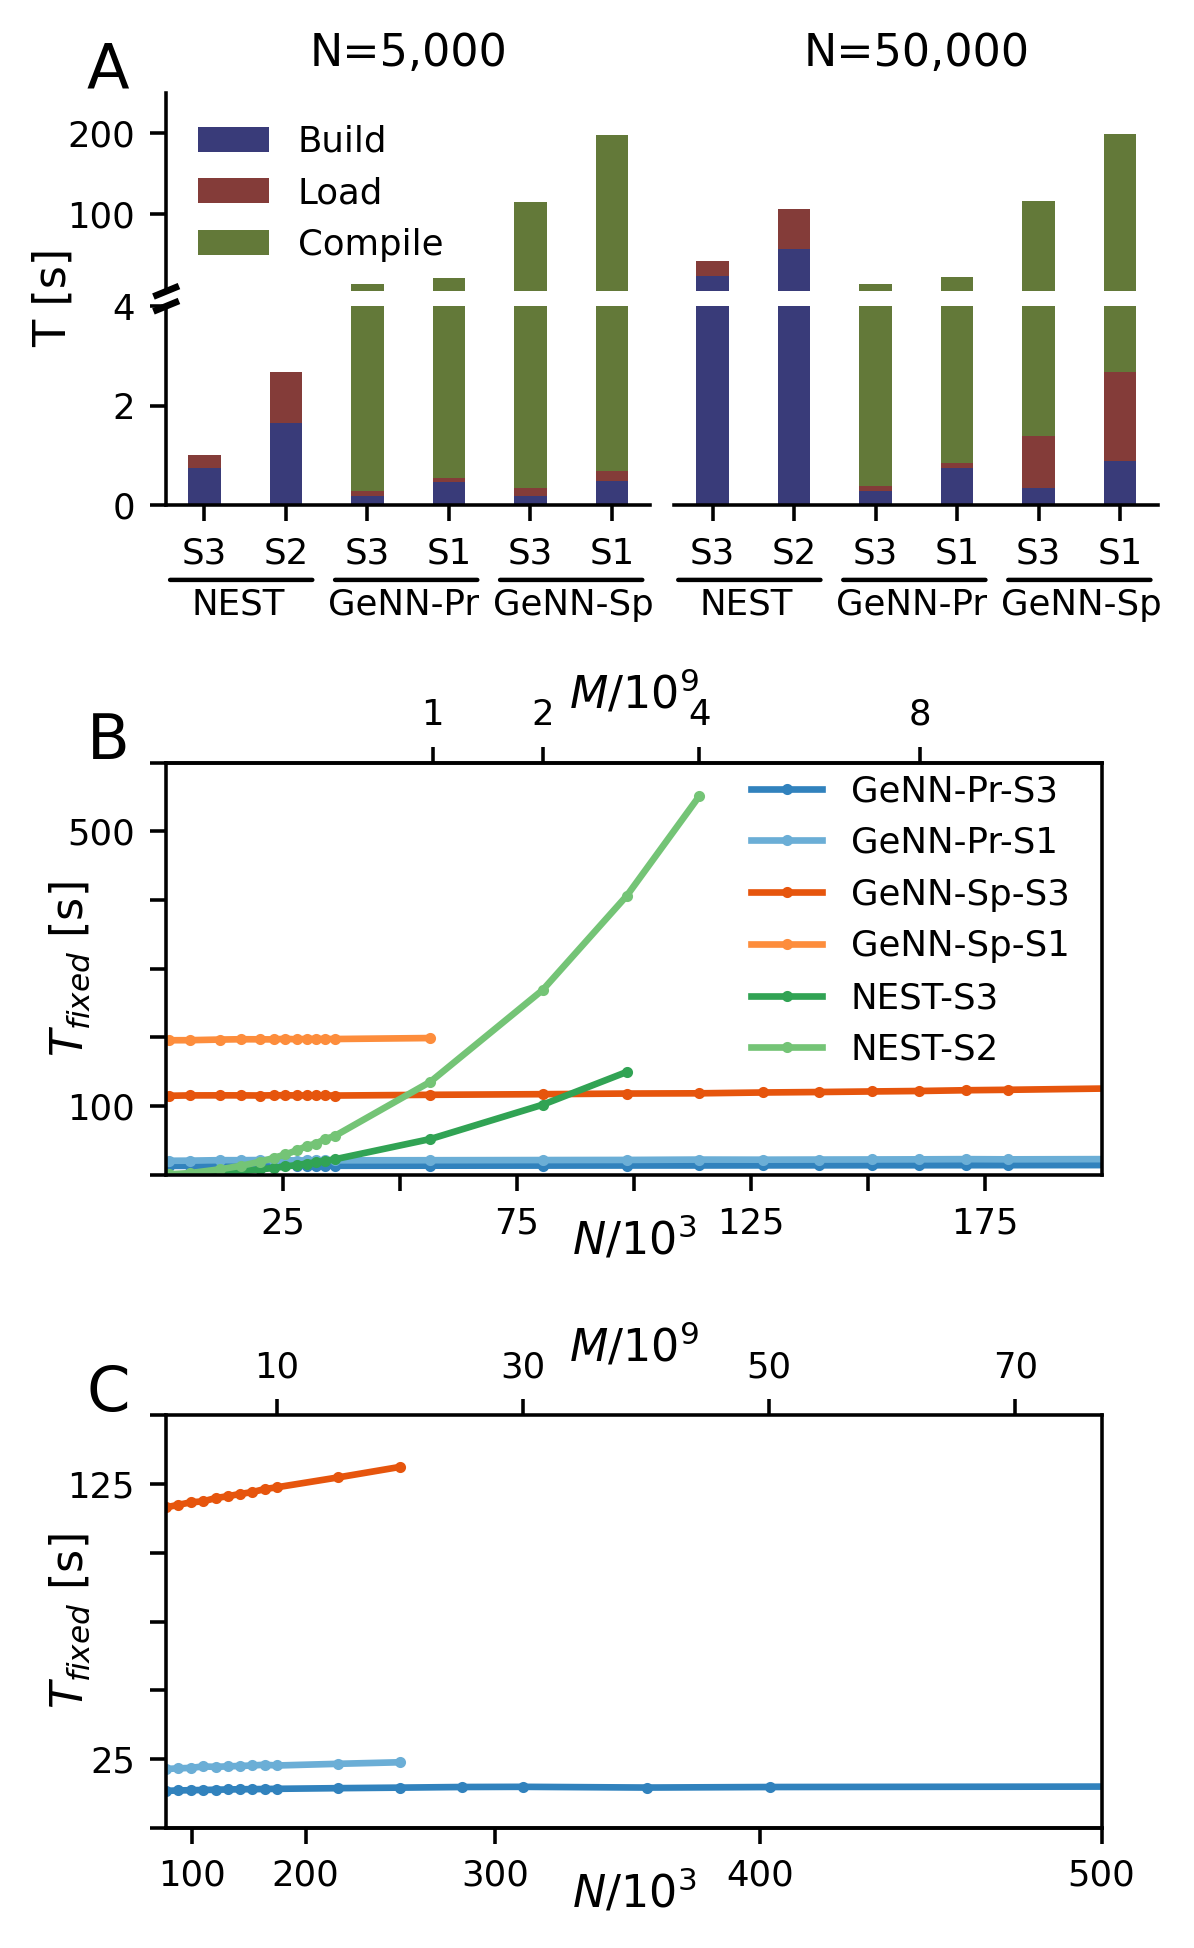

In [5]:
Configurations=6
width=0.4
matplotlib.rcParams['axes.prop_cycle'] =cmap_Bar


fig = plt.figure(figsize=(9*cm, 15*cm), dpi=320)
plt.figtext(0.005, 0.975, "A", fontsize=fontsizeSubfigure)



subfigs = fig.subfigures(3, 1, height_ratios=[0.75, 1.0, 1.0])
dictGrid={'left':0.125,
                    'bottom':0.1,
                    'left':0.075,
                    'right':0.95,
                    'top':0.9,
                    'wspace':0.05,
                    'hspace':0.075}

ax = subfigs[0].subplots(2, 2, gridspec_kw=dictGrid)


FixcostStack=df_5k_50k_Fixcost.filter(items=['Build', 'Compile', 'Load'])
# Definition of barplot by using variable outside of function
def Func_barplot(lower, upper, axs=ax[0,0]):
    axs.bar(df_5k_50k_Fixcost[0:Configurations]['Print'], FixcostStack[lower:upper]['Build'], width, label='Build')
    axs.bar(df_5k_50k_Fixcost[0:Configurations]['Print'], FixcostStack[lower:upper]['Load'], width, bottom=FixcostStack[lower:upper]['Build'], label='Load')
    axs.bar(df_5k_50k_Fixcost[0:Configurations]['Print'], FixcostStack[lower:upper]['Compile'], width, bottom=FixcostStack[lower:upper]['Build'] + FixcostStack[lower:upper]['Load'], label='Compile')
    return 0
Func_barplot(0, Configurations, ax[0,0])
Func_barplot(0, Configurations, ax[1,0])



ax[0,0].legend(fontsize=fontsizeLegend)
ax[0,0].set_ylim(4, 250)  # outliers only
ax[1,0].set_ylim(0, 4)  # most of the data
ax[1,0].tick_params(axis='y', labelsize=fontsizeTicks)
ax[0,0].tick_params(axis='y', labelsize=fontsizeTicks)
#ax[0,0].set_title("N=" + str(int(Fixcost[0:1]["N_E"].tolist()[0]*1.25)), fontsize=fontsizeLabels)
ax[0,0].set_title("N=" + str('{:,}'.format(int(df_5k_50k_Fixcost[0:1]["N_E"].tolist()[0] * 1.25))), fontsize=fontsizeLabels)


labels= df_5k_50k_Fixcost[0:Configurations]["Print"].tolist()
labels=[x[-2:] for x in labels]
ax[1,0].set_xticklabels(labels,rotation = 0,linespacing=1.0, fontsize=fontsizeTicks)

ax[1,0].annotate('', xy=(-5, -75), xycoords='axes pixels', xytext=(155, -75),
            arrowprops=dict(arrowstyle="-", color='k'))
ax[1,0].annotate("NEST", xy=(25, -110), xycoords='axes pixels', fontsize=fontsizeTicks)


ax[1,0].annotate('', xy=(160, -75), xycoords='axes pixels', xytext=(320, -75),
            arrowprops=dict(arrowstyle="-", color='k'))
ax[1,0].annotate("GeNN-Pr", xy=(162, -110), xycoords='axes pixels', fontsize=fontsizeTicks)


ax[1,0].annotate('', xy=(325, -75), xycoords='axes pixels', xytext=(485, -75),
            arrowprops=dict(arrowstyle="-", color='k'))
ax[1,0].annotate("GeNN-Sp", xy=(327, -110), xycoords='axes pixels', fontsize=fontsizeTicks)



ax[0,0].spines['bottom'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)



# Params for diagonal break line
d = .020  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax[0,0].transAxes, color='k', clip_on=False, linewidth=1.5)
ax[0,0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
kwargs.update(transform=ax[1,0].transAxes)  # switch to the bottom axes
ax[1,0].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax[1,0].set_xlabel('')
ax[1,0].set_ylabel('')

Func_barplot(Configurations, Configurations+Configurations, ax[0,1])
Func_barplot(Configurations, Configurations+Configurations, ax[1,1])

ax[0,1].set_title("N=" + str('{:,}'.format(int(df_5k_50k_Fixcost[Configurations:Configurations + 1]["N_E"].tolist()[0] * 1.25))), fontsize=fontsizeLabels)

labels= df_5k_50k_Fixcost[Configurations:2 * Configurations]["Print"].tolist()
labels=[x[-2:] for x in labels]
ax[1,1].set_xticklabels(labels,rotation = 0,linespacing=1.0, fontsize=fontsizeTicks)

ax[1,1].annotate('', xy=(-5, -75), xycoords='axes pixels', xytext=(155, -75),
            arrowprops=dict(arrowstyle="-", color='k'))
ax[1,1].annotate("NEST", xy=(25, -110), xycoords='axes pixels', fontsize=fontsizeTicks)

ax[1,1].annotate('', xy=(160, -75), xycoords='axes pixels', xytext=(320, -75),
            arrowprops=dict(arrowstyle="-", color='k'))
ax[1,1].annotate("GeNN-Pr", xy=(162, -110), xycoords='axes pixels', fontsize=fontsizeTicks)

ax[1,1].annotate('', xy=(325, -75), xycoords='axes pixels', xytext=(485, -75),
            arrowprops=dict(arrowstyle="-", color='k'))
ax[1,1].annotate("GeNN-Sp", xy=(327, -110), xycoords='axes pixels', fontsize=fontsizeTicks)

ax[0,1].set_ylim(4, 250)  # outliers only
ax[1,1].set_ylim(0, 4)  # most of the data

ax[0,0].spines['right'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)

ax[0,1].spines['bottom'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)


ax[1,1].xaxis.tick_bottom()
ax[1,1].set_xlabel('')
ax[1,1].set_xlabel('')
ax[1,1].set_ylabel('')
ax[0,1].set_ylabel('')
ax[0,0].legend(fontsize=fontsizeTicks, loc=2, frameon=False)


ax[0,0].xaxis.set_ticks_position('none')
ax[0,1].xaxis.set_ticks_position('none')
ax[0,1].yaxis.set_ticks_position('none')
ax[1,1].yaxis.set_ticks_position('none')
ax[0,0].spines['top'].set_visible(False)


ax[1,1].get_yaxis().set_ticks([])
ax[0,1].get_yaxis().set_ticks([])

ax[0,0].get_xaxis().set_ticks([])
ax[0,1].get_xaxis().set_ticks([])

ax=plt.gca()

subfigs[0].add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.ylabel('T [s]')

#####################################################################################
##################  Plot fixed cost - variable size  ################################
#####################################################################################
matplotlib.rcParams['axes.prop_cycle'] =cmap_Var

plt.figtext(0.005, 0.62, "B", fontsize=fontsizeSubfigure)

dictGrid={'left':0.125,
                    'bottom':0.1,
                    'left':0.075,
                    'right':0.9,
                    'top':0.7,
                    'wspace':0.05,
                    'hspace':0.075}

ax = subfigs[1].subplots(1, 1, gridspec_kw=dictGrid)

PrintM=np.unique(df_variableSize["Print"])


for printMat in PrintM:
    subDF=df_variableSize[df_variableSize["Print"]==printMat]
    subDF.sort_values(by=['N_E'])
    p=ax.plot(subDF["N_E"]*1.25/1000, subDF["TotalFix"],'.-', label=(NamesPrint[printMat][0]).replace("\n", ""),  markersize=3)
    colorLine=p[0].get_color()    
ax.legend(loc=1, fontsize=fontsizeLegend, frameon=False, bbox_to_anchor=(1.0, 1.05))


ticks=np.arange(25, 200, 25)
ax.xaxis.set(ticks=ticks)
Labels=["" for ii in ticks]
Labels[0]=ticks[0]
Labels[2]=ticks[2]
Labels[4]=ticks[4]
Labels[6]=ticks[6]
ax.xaxis.set( ticklabels=Labels)
ax.set_xlim(0, 200)
ax.set_ylim(0,600)
ticks=np.arange(0, 601, 100)
ax.yaxis.set(ticks=ticks)
Labels=["" for ii in ticks]
Labels[1]=ticks[1]
Labels[-2]=ticks[-2]
ax.yaxis.set( ticklabels=Labels)


plt.ylabel(r'$T_{fixed}$ [s]', fontsize=fontsizeLabels, labelpad=-5.5)
ax.set_xlabel(r'$N/10^3$', fontsize=fontsizeLabels, labelpad=-5.5)

secax = ax.secondary_xaxis('top', functions=(lambda x: NtoM9(x*1e3), lambda x: MtoN(x*1e9)))
secax.set_ticks([1,2, 4, 8, 16])
secax.set_xlabel(r'$M/10^9$', fontsize=fontsizeLabels, labelpad=-2.5)

ax.tick_params(axis='x', labelsize=fontsizeTicks )
ax.tick_params(axis='y', labelsize=fontsizeTicks )
secax.tick_params(axis='x', labelsize=fontsizeTicks )



####################   C ###############################
plt.figtext(0.005, 0.275, "C", fontsize=fontsizeSubfigure)

dictGrid={'left':0.125,
                    'bottom':0.15,
                    'left':0.075,
                    'right':0.9,
                    'top':0.75,
                    'wspace':0.05,
                    'hspace':0.075}

ax = subfigs[2].subplots(1, 1, gridspec_kw=dictGrid)


for printMat in PrintM[0:3]:
	subDF=df_variableSize[df_variableSize["Print"]==printMat]
	subDF.sort_values(by=['N_E'])
	subDF.sort_values(by=['N_E'])
	p=ax.plot(NtoM(subDF["N_E"]*1.25)/1e9, subDF["TotalFix"],'.-', label=(NamesPrint[printMat][0]).replace("\n", ""),  markersize=3)
	colorLine=p[0].get_color()
plt.xticks([5000, 25000, 50000, 100000])
ax.set_xlim(1,77)
ax.set_ylim(0, 150)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

ax.set_xlabel(r'$M/10^9$', fontsize=fontsizeLabels, labelpad=-2.5)
ax.set_ylabel(r'${T_{fixed}} $ [s]', fontsize=fontsizeLabels, rotation=90, labelpad=-5.5)


secax = ax.secondary_xaxis('bottom', functions=(lambda x: M9toN(x)/1000, lambda x: NtoM9(x*1000)))
secax.set_ticks([100, 200, 300,400, 500])
ticks=np.arange(10, 80, 20)
ax.xaxis.set(ticks=ticks)
Labels=[ii for ii in ticks]
ax.xaxis.set( ticklabels=Labels)
ticks=np.arange(0, 151, 25)
ax.yaxis.set(ticks=ticks)
Labels=["" for ii in ticks]
Labels[1]=ticks[1]
Labels[-2]=ticks[-2]

ax.yaxis.set( ticklabels=Labels)

ax.tick_params(axis='x', labelsize=fontsizeTicks )
ax.tick_params(axis='y', labelsize=fontsizeTicks )
secax.tick_params(axis='x', labelsize=fontsizeTicks )

secax.set_xlabel(r'$N/10^3$', labelpad=-5.5, fontsize=fontsizeLabels)

plt.savefig("Figure3.png", bbox_inches="tight")                

# Figure 4

In [6]:
df_variableSizeFig4=df_variableSize.copy(deep=True)

# add simulations to determine Realtime Value - we didn't ensure recompilation -> fixed costs of these are not useful
dfRT=LoadData(PathRT)
dfRT["Print"]=dfRT.apply(lambda x: GenerateName(x.Backend, x.matrixType), axis=1)
dfRT["TotalBiol"]=dfRT.apply(lambda x: (x.simtime+x.warmup)/1000, axis=1)
dfRT["RT"]=dfRT.apply(lambda x: (np.sum(x.Sim)+np.sum(x.Download))/x.TotalBiol, axis=1)
dfRT['TotalFix']=dfRT.apply(lambda x: x.Build+x.Compile+x.Load, axis=1)
dfRT=dfRT.groupby(['N_E','Print']).agg({"TotalFix": lambda x: np.nan, "e_rate": "median", "RT": "median"}).reset_index()

for size , Print  in [(12560,"Nest"),(6320, "Nest_old"), 
                                    (75440, "GeNN-\nSparse"), (21520, "GeNN-\nSparse_old"),
                                    (15360,"GeNN-\nProc"),(5120, "GeNN-\nProc_old")]:
    df_variableSizeFig4=df_variableSizeFig4.append(dfRT[(dfRT['Print']==Print) & (dfRT['N_E']==size)])
df_variableSizeFig4.sort_values(['N_E'], inplace=True)

Loaded: /home/felix/Documents/BenchmarkGeNN/RepoPublication/SNN_GeNN_Nest/Data/TimeSim_Size/RT/GeNN_S1_RT.pkl
Loaded: /home/felix/Documents/BenchmarkGeNN/RepoPublication/SNN_GeNN_Nest/Data/TimeSim_Size/RT/NEST_S2_RT.pkl
Loaded: /home/felix/Documents/BenchmarkGeNN/RepoPublication/SNN_GeNN_Nest/Data/TimeSim_Size/RT/GeNN_S3_RT.pkl
Loaded: /home/felix/Documents/BenchmarkGeNN/RepoPublication/SNN_GeNN_Nest/Data/TimeSim_Size/RT/NEST_S3_RT.pkl
Total number of Rows loaded:  260


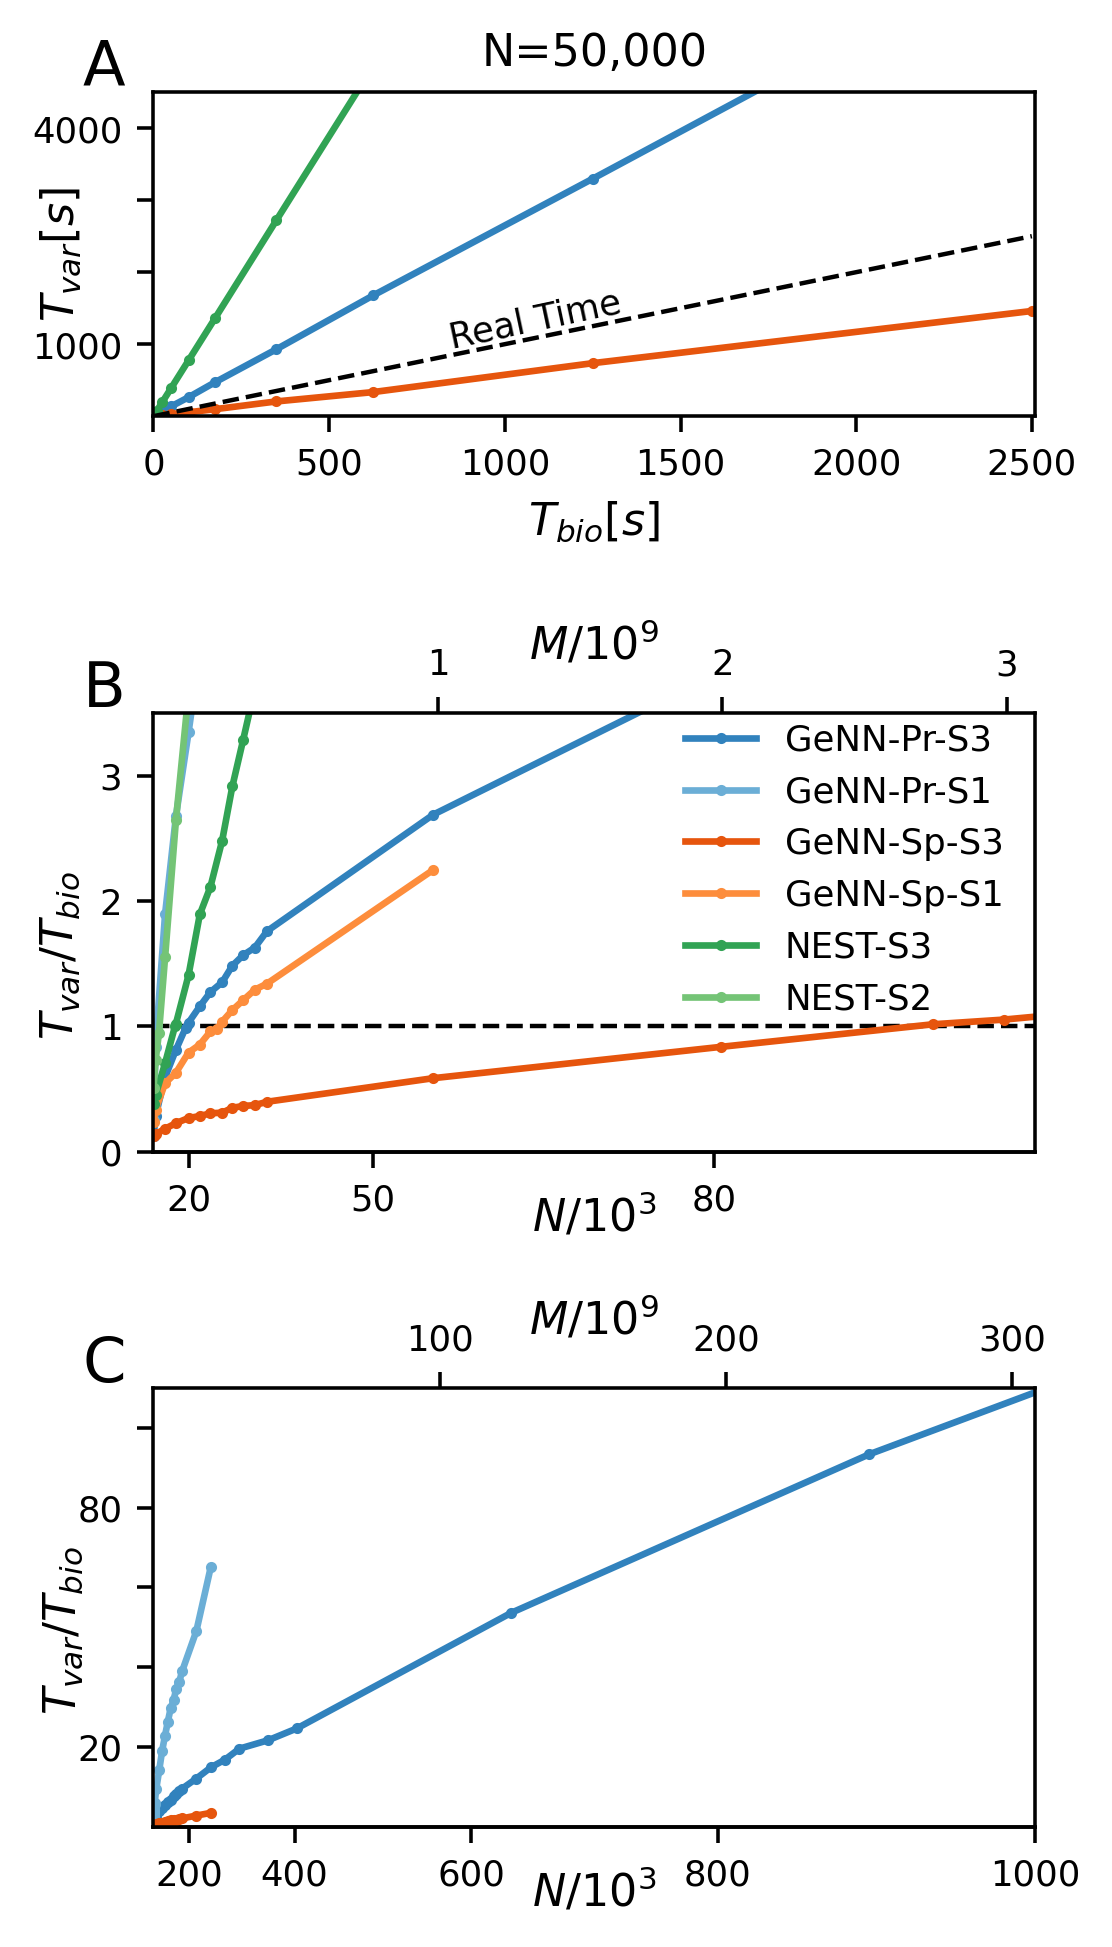

In [7]:
mpl.rcParams['axes.prop_cycle'] =cmap_Var


fig = plt.figure(figsize=(8*cm, 15*cm), dpi=320)
plt.figtext(0.005, 0.975, "A", fontsize=fontsizeSubfigure)



subfigs = fig.subfigures(3, 1, height_ratios=[0.8, 1., 1.])
dictGrid={'left':0.125,
                    'bottom':0.3,
                    'left':0.075,
                    'right':0.95,
                    'top':0.9,
                    'wspace':0.05,
                    'hspace':0.075}

ax = subfigs[0].subplots(1, 1, gridspec_kw=dictGrid)

N_E=[40000]
Simulators=np.unique(df_5k_50k_Variable["Print"])
Simulators=['GeNN-\nProc', 'GeNN-\nSparse','Nest']


df_5k_50k_Variable=df_5k_50k_Variable.groupby(["N_E", "Print", 'TotalBiol']).median().reset_index()
for N in N_E:
    for printS in Simulators:
        ax.plot(df_5k_50k_Variable.loc[(df_5k_50k_Variable["Print"]==printS)&(df_5k_50k_Variable["N_E"]==N), "TotalBiol"], 
                df_5k_50k_Variable.loc[(df_5k_50k_Variable["Print"]==printS)&(df_5k_50k_Variable["N_E"]==N), "TotalDyn"], '.-', label=printS,   markersize=markersize)
        next(ax._get_lines.prop_cycler)
    

ax.plot([0, 2500], [0,2500], 'k--',  linewidth=1)  
l2 = np.array([850, 950])
#Rotate angle
angle = 12
th2 = ax.text(*l2, 'Real Time', fontsize=fontsizeTicks,
              rotation=angle, rotation_mode='anchor')


ax.set_xlim(0, 2510)
ax.set_ylim(0, 4500)
ax.set_xlabel('$T_{bio} [s]$', fontsize=fontsizeLabels)
ax.set_ylabel('$T_{var} [s]$', fontsize=fontsizeLabels, labelpad=-11.5)

ticks=np.arange(1000, 4001, 1000)
ax.yaxis.set(ticks=ticks)
Labels=["" for ii in ticks]
Labels[0]=ticks[0]
Labels[-1]=ticks[-1]

ax.yaxis.set( ticklabels=Labels)

ax.tick_params(axis='x', labelsize=fontsizeTicks )
ax.tick_params(axis='y', labelsize=fontsizeTicks )
ax.set_title("N=" + str('{:,}'.format(int(N_E[0]*1.25))), fontsize=fontsizeLabels)


#####################################################################################
##################  Plot fixed cost - variable size  ################################
#####################################################################################
mpl.rcParams['axes.prop_cycle'] =cmap_Var

plt.figtext(0.005, 0.6465, "B", fontsize=fontsizeSubfigure)
dictGrid={'left':0.125,
                    'bottom':0.15,
                    'left':0.075,
                    'right':0.95,
                    'top':0.8,
                    'wspace':0.05,
                    'hspace':0.075}

ax = subfigs[1].subplots(1, 1, gridspec_kw=dictGrid)

PrintM=np.unique(df_variableSizeFig4["Print"])
#PrintM=['GeNN-\nProc', 'GeNN-\nSparse', 'Nest']
ax.plot([0, 10], [1.0,1.0], 'k--',  linewidth=1) 

for printMat in PrintM:
    p=ax.plot(NtoM9(df_variableSizeFig4.loc[(df_variableSizeFig4["Print"]==printMat), "N_E"]*1.25),df_variableSizeFig4.loc[(df_variableSizeFig4["Print"]==printMat), "RT"], 
              '.-', label=(NamesPrint[printMat][0]).replace("\n", ""),   markersize=markersize)

ax.legend(loc=1, fontsize=fontsizeLegend, frameon=False, bbox_to_anchor=(1.0, 1.05))


ax.set_ylim(0, 3.5)
ax.set_xticks([1, 2, 3])
ax.set_xlim(0,3.1)

secax = ax.secondary_xaxis('bottom', functions=(lambda x: M9toN(x)/1e3, lambda x: NtoM9(x*1e3)))
secax.set_ticks([20,  50, 80, 110])

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

ax.set_xlabel(r'$M/10^9$', fontsize=fontsizeLabels,  labelpad=-2.5)
ax.set_ylabel(r'$T_{var}/T_{bio} $    ', fontsize=fontsizeLabels, rotation=90)
secax.set_xlabel(r'$N/10^3$', labelpad=-5.5, fontsize=fontsizeLabels)

ax.tick_params(axis='x', labelsize=fontsizeTicks )
ax.tick_params(axis='y', labelsize=fontsizeTicks )
secax.tick_params(axis='x', labelsize=fontsizeTicks )



####################   C ###############################
plt.figtext(0.005, 0.289, "C", fontsize=fontsizeSubfigure)

dictGrid={'left':0.125,
                    'bottom':0.15,
                    'left':0.075,
                    'right':0.95,
                    'top':0.8,
                    'wspace':0.05,
                    'hspace':0.075}

ax = subfigs[2].subplots(1, 1, gridspec_kw=dictGrid)

PrintM=np.unique(df_variableSizeFig4["Print"])



for printMat in PrintM[0:3]:
    p=ax.plot(NtoM9(df_variableSizeFig4.loc[(df_variableSizeFig4["Print"]==printMat), "N_E"]*1.25),df_variableSizeFig4.loc[(df_variableSizeFig4["Print"]==printMat), "RT"], 
              '.-', label=(NamesPrint[printMat][0]).replace("\n", ""),   markersize=markersize)

secax = ax.secondary_xaxis('bottom', functions=(lambda x: M9toN(x)/1e3, lambda x: NtoM9(x*1e3)))
secax.set_ticks([200,  400, 600, 800, 1000])

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xticks([100, 200, 300], fontsize=fontsizeTicks)
ax.set_yticks([20, 40, 60, 80], fontsize=fontsizeTicks)

ax.set_xlim(0,308)

ax.set_ylim(0, 110)

ax.set_xlabel(r'$M/10^9$', fontsize=fontsizeLabels,  labelpad=-2.5)
ax.set_ylabel(r'$T_{var}/T_{bio} $    ', fontsize=fontsizeLabels, rotation=90,labelpad=-1.85)
secax.set_xlabel(r'$N/10^3$', labelpad=-5.5, fontsize=fontsizeLabels)


ticks=np.arange(20, 101, 20)
ax.yaxis.set(ticks=ticks)
Labels=["" for ii in ticks]
Labels[0]=ticks[0]
Labels[-2]=ticks[-2]

ax.yaxis.set( ticklabels=Labels)

ax.tick_params(axis='x', labelsize=fontsizeTicks )
ax.tick_params(axis='y', labelsize=fontsizeTicks )
secax.tick_params(axis='x', labelsize=fontsizeTicks )

plt.savefig("Figure4.png", bbox_inches="tight")

# Regression of variable costs

GeNN-
Pr-S3
a0= 0.10929755512262432
a1= 3.892958407460556e-05
a2= 2.3850356916298083e-10
############################################
GeNN-
Pr-S1
a0= 0.1700839224653555
a1= 0.00014507491235983186
a2= 1.3240852592795893e-09
############################################
GeNN-
Sp-S3
a0= 0.11167462025295148
a1= 7.096502705267377e-06
a2= 7.707402636648204e-11
############################################
GeNN-
Sp-S1
a0= 0.22541303691568193
a1= 2.285929877632814e-05
a2= 7.477579458498552e-10
############################################
NEST-S3
a0= 0.42051170238825686
a1= -2.1722218986399482e-05
a2= 1.1820833788887613e-08
############################################
NEST-S2
a0= 0.6074315518979707
a1= -6.73898244068993e-05
a2= 3.960600796600191e-08
############################################


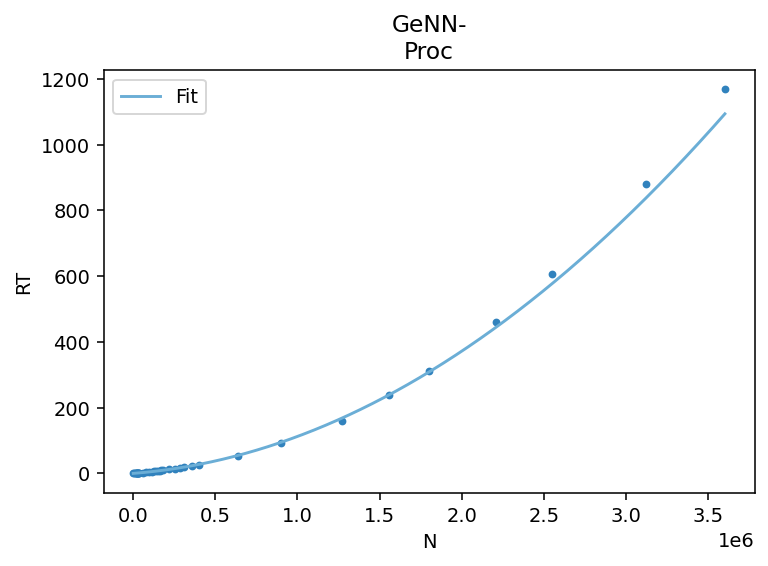

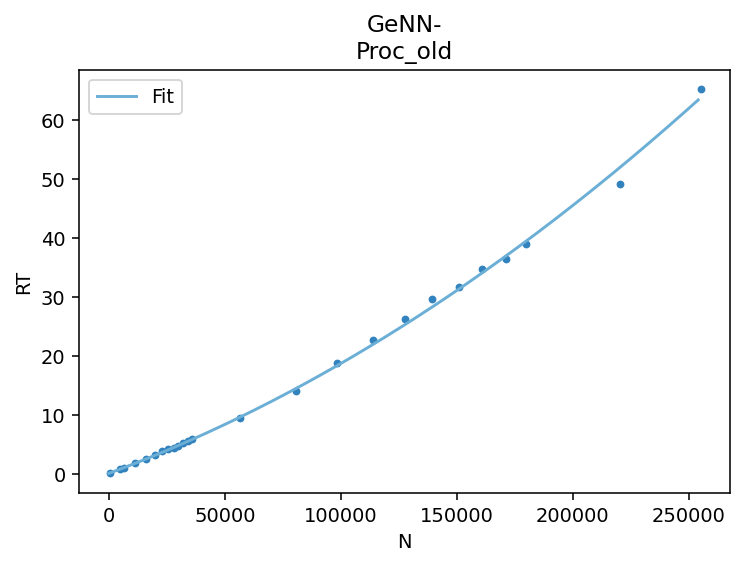

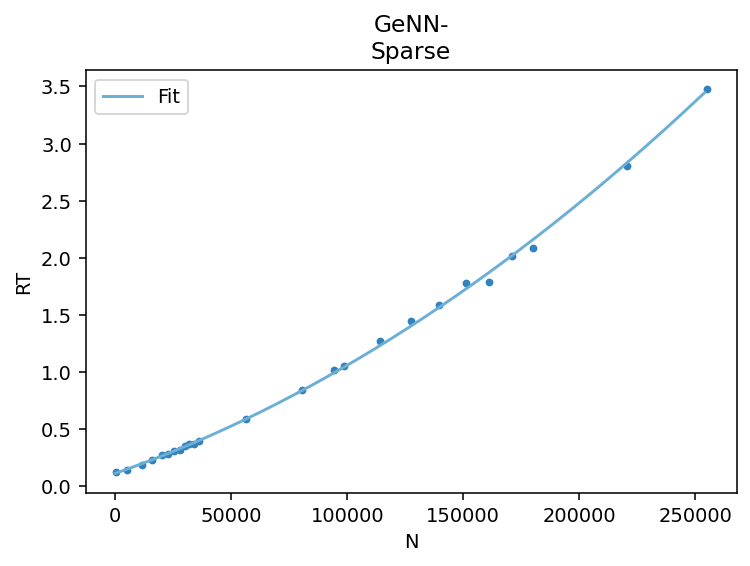

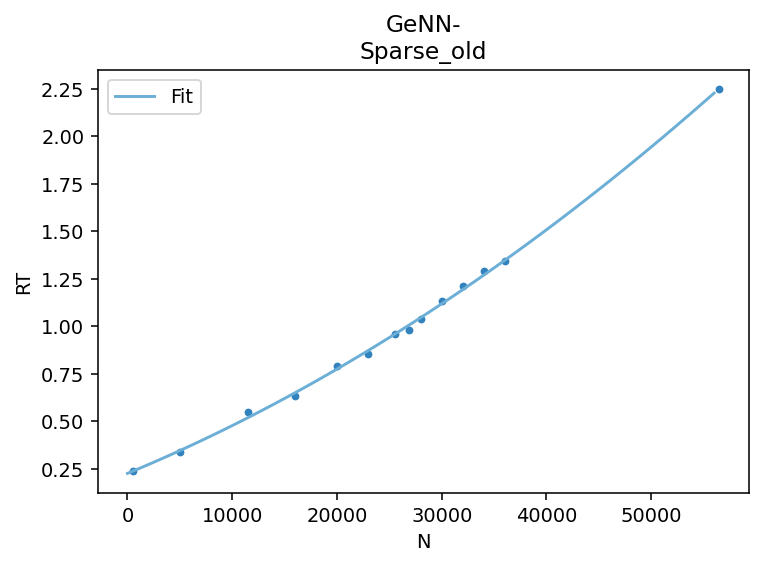

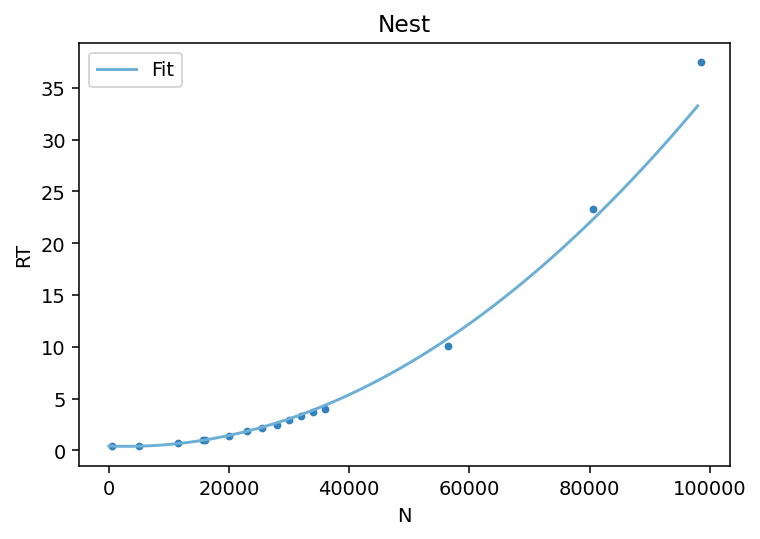

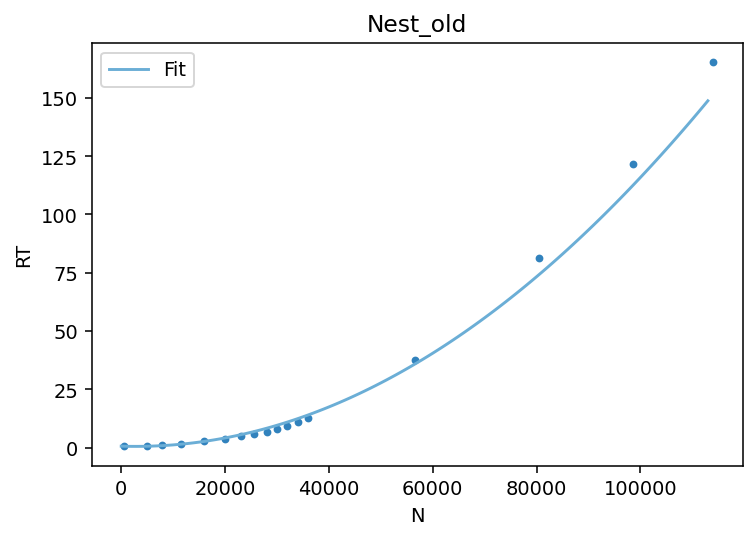

In [12]:
def fun(a, x, y, z, d):
    return ((genfun(a, x)  - y)/y)*np.sqrt(d/z+1-d)


def genfun(a, x):
    return a[0] + a[1] * x + a[2]*(0.308*(x**2))


a0=np.array([0, 0.0, 0.1])

for name, group in df_variableSizeFig4.groupby(['Print']):
    fig=plt.figure(dpi=140)
    plt.title(name)
    plt.plot(1.25*group['N_E'], group['RT'],'.')
    sizes=np.unique(group['N_E'])
    kde = KernelDensity(kernel='gaussian', bandwidth=10000).fit(1.25*sizes.reshape(-1, 1))
    sizeTest=1.25*group['N_E'].to_numpy()
    Densities= np.exp(kde.score_samples(sizeTest.reshape(-1, 1)))
    Densities=Densities/np.max(Densities)

    print(NamesPrint[name][0])
    
    res_lsq = sco.least_squares(fun, a0, args=(1.25*group['N_E'], group['RT'], Densities, 0.75 ))
    print("a0=",res_lsq['x'][0])
    print("a1=",res_lsq['x'][1])
    print("a2=",res_lsq['x'][2])
    sizeTest=np.arange(0, 1.25*sizes[-1], 1000)
    plt.plot(sizeTest, genfun(res_lsq.x, sizeTest), label='Fit')
    
    plt.legend()
    plt.xlabel('N')
    plt.ylabel('RT')

    print("############################################")
    